<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/ISPC_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the libraries we need


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
%matplotlib inline

# Create Frequency Signals
Generate Some nice heavily messed up signals that we can investigate later.

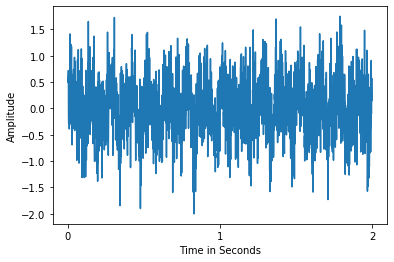

In [0]:
# first we need some functions to generate and visualize data

def generate_signal(length, sfreq, frequencies, amplitudes, phases, noise_level):
  """
  Generate a signal, as a sum of multiple independent sine wave components, where each sine is defined by:

  amplitude * sin( 2 * pi * frequency * x + phase)

  Afterwards add some gaussian noise with a std of `noise_level` to the data.
  In order to work, the frequencies, amplitudes and phases lists must be of the same length.
  """

  x = np.linspace(0, length, sfreq * length)
  signal = np.sum([amp * np.sin( 2 * np.pi * freq * x  + phase) for freq, amp, phase in zip(frequencies, amplitudes, phases)], axis=0)
  return signal + noise_level * np.random.randn(length * sfreq)


def plot_signal(signal, sfreq):
  """Plot a signal given the signal and the sampling frequency."""
  
  plt.figure()
  plt.plot(signal)
  plt.xticks(range(0,len(signal) + 1, sfreq))
  plt.xlabel("Time in Seconds")
  plt.ylabel("Amplitude")
  ax = plt.gca()
  ax.set_xticklabels(range(0,int(len(signal)/sfreq) + 1,1))
  plt.show()


# Now we can generate a signal and plot it
length = 2
sfreq = 1000
frequencies = [8, 14, 22, 22.01]
amplitudes =  [0.3, 0.2, 2, -2]
phases =      [0, 0.6, np.pi, np.pi]
noise_level = 0.5
sig = generate_signal(length, sfreq, frequencies, amplitudes, phases, noise_level)
plot_signal(sig, sfreq)


# The Fourier Transform

First, a short study on Fourier Transform to get better intuition.

Check out this video first to get an understanding for the following function:

https://www.youtube.com/watch?v=spUNpyF58BY



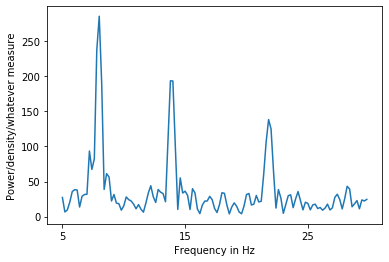

In [0]:
# From the formula in the video, we can define a fourier transform for a single frequency
def single_freq_fourier(signal, freq, sfreq):
  return np.sum( [sig[t] * np.exp(- 2 * np.pi * 1j * freq * t/sfreq) for t in range(len(signal))])


# To get interesting results, we have to perform the fourier analysis over a range of frequencies and compare them
def calculate_full_fourier(signal, frequencies, sfreq):
  return [single_freq_fourier(signal, freq, sfreq) for freq in frequencies]


# If we did the fourier transform on a continuous set of frequencies, we can easily plot them
def plot_fourier(transform, fmin, fmax, f_res):
  transform = transform
  plt.figure()
  plt.plot(transform)
  plt.xticks(range(0,len(transform) + 1, f_res * 10))
  plt.xlabel("Frequency in Hz")
  plt.ylabel("Power/density/whatever measure")
  ax = plt.gca()
  ax.set_xticklabels(range(fmin,fmax + 1, 10))
  plt.show()


# Example: Analyse the signal "sig" from above, using:
# a frequency range from fmin to fmax
# with [f_res] subfrequencies per frequency
fmin = 5
fmax = 30
f_res = 5
frequencies = np.linspace(fmin, fmax, f_res * (fmax - fmin))
transform = calculate_full_fourier(sig, frequencies, sfreq)

# now plot the transform
plot_fourier(np.abs(transform), fmin, fmax, f_res)

# as you can see, the plot below matches the frequencies we defined for our signal sig
# feel free to play around with this to get some intuition


# Phase Angles

Before Getting started, we first should have a look at the Phase Angle Vectors, since ISPC is calculated on the Phase Angle.

For more information, check out Mike Cohen's video:

https://www.youtube.com/watch?v=4vwj7t6yDQk

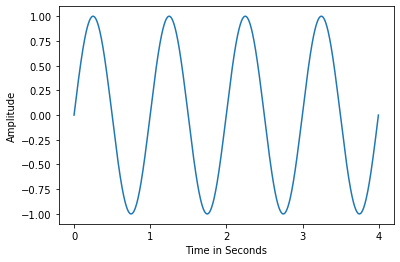

Frequencies used by stft:  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Text(0, 0.5, 'Phase Angle')

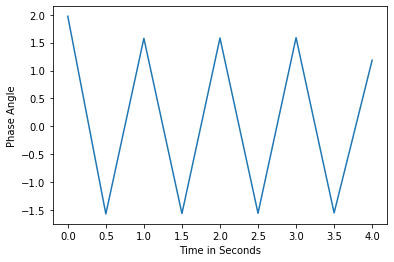

In [0]:
# first we construct the phase angle vectors for a 1 Hz wave
sfreq = 256
sig = generate_signal(length=4, sfreq=sfreq, frequencies=[1], amplitudes=[1], phases=[0], noise_level=0)
plot_signal(sig, sfreq)

# We create the phase angle vector by doing a fourier transform and taking the angle of the imginary number
# To make life easier, we use scipy's implementation of a fourier transform, which works way faster than ours
freqs, times, signal_stft = scipy.signal.stft(sig, fs=sfreq)
phase_angles = np.angle(signal_stft)

# The scipy fourier transform runs over a linspace-like spectrum of frequencies (similar to the one we used before)
# To get a certain frequency, we can look into the first 10 freqs our frequency vector
print("Frequencies used by stft: ", freqs[:10])

# We pick out the frequency one to see the phase angle at 1Hz of our 1Hz sine wave
plt.plot(times, phase_angles[1, :])
plt.xlabel("Time in Seconds")
plt.ylabel("Phase Angle")


# The ISPC

Now we can implement the ISPC. Again, for a reference, see:

https://www.youtube.com/watch?v=4vwj7t6yDQk

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


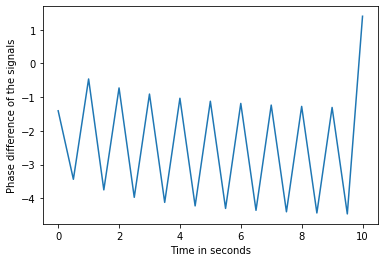

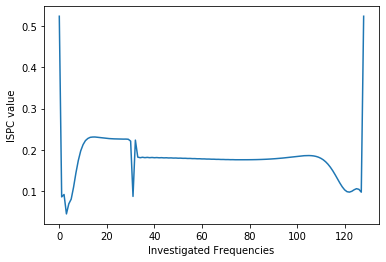

In [0]:
# First, we generate two simple signals (2 Hz and 3 Hz)that we can later compare to each other
sfreq = 256 # Hz
length = 10 # Seconds
sig_1 = generate_signal(length, sfreq, frequencies=[2], amplitudes=[1], phases=[0], noise_level=0)
sig_2 = generate_signal(length, sfreq, frequencies=[31], amplitudes=[1], phases=[0.02], noise_level=0)

# As our EEG data are also a matrix of stacked signals, we generate a likewise matrix from our two "channels"
signals = np.vstack([sig_1, sig_2])

# now do the fourier transform and get the phase angle vectors again:
freqs, times, signal_stft = scipy.signal.stft(signals, fs=sfreq, axis=-1)
phase_angles = np.angle(signal_stft)

# subtract the phase angles (which are stored now in the [0] and [1] indices of our matrix)
phase_diff = phase_angles[0] - phase_angles[1]

# plot the phase difference for the 2 Hz frequency
plt.plot(times, phase_diff[freqs==2].T)
plt.ylabel("Phase difference of the signals")
plt.xlabel("Time in seconds")

# now, it's time to define the ISPC function
def core_ispc(phase_diff, times):
  """A simple implementation of the ISPC formula as described by Cohen."""
  return (1/len(phase_diff)) * np.sum([np.exp(1j * (phase_diff[t]) * times[t]) for t in range(len(phase_diff))])


# Calculate the ISPC values for all analyzed frequencies of our two signals
ispc_over_freqs = [core_ispc(phase_diff[freq], times) for freq in range(len(freqs))]


# plot the ISPC values
plt.figure()
plt.plot(freqs, ispc_over_freqs)
plt.xlabel("Investigated Frequencies")
plt.ylabel("ISPC value")
plt.show()


Of course, it's super annoying to do all these steps consecutive, so we just define our function that does everything together on our [channels*times] EEG-like signal block.

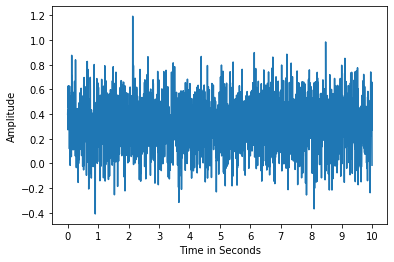

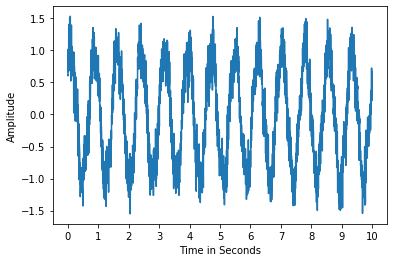

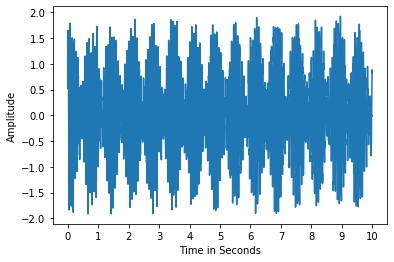

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


Shape of our ISPC matrix:  (24, 24, 129)


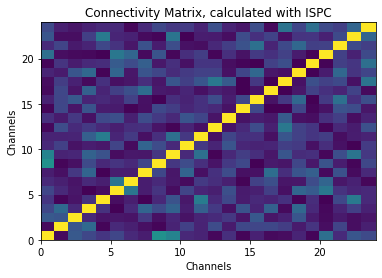

In [0]:
def full_ispc(data, sfreq):
  """
  Perform the ISPC on a signal matrix.
  The data must be of shape [n_signals, n_timesteps].
  
  Returns:
  A matrix of shape [n_signals, n_signals, n_frequencies] as well as
  an array containing the analyzed frequencies.
  """

  n_chans = len(data) 
  freqs, times, signal_stft = scipy.signal.stft(data, fs=sfreq, axis=-1)
  phase_angles = np.angle(signal_stft)

  # create an empty ISPC matrix that we can fill up with all the values
  ispc_matrix = np.empty([n_chans, n_chans, len(freqs)])

  # loop over all channels x all channels
  for chan_a in range(n_chans):
    for chan_b in range(n_chans):

      # Calculate the Phase Difference Vector and the ISPC for all frequencies
      phase_diff = phase_angles[chan_a] - phase_angles[chan_b]
      ispc_matrix[chan_a, chan_b, :] = np.array([core_ispc(phase_diff[freq], times) for freq in range(len(freqs))])

  return np.abs(ispc_matrix), freqs


# generate some more data (24 channels, 10 seconds, 256 samples per second)
n_chans = 24
sfreq = 256
length = 10
data = np.vstack([generate_signal(length, sfreq,
                                     frequencies= [1 + i, 0.25 * i**1.5],
                                     amplitudes=  [np.sin(i), 1],
                                     phases=      [0, np.random.rand(1)],
                                     noise_level=0.2) for i in range(n_chans)])

# plot some channels to see how they look
plot_signal(data[0], sfreq)
plot_signal(data[3], sfreq)
plot_signal(data[15], sfreq)


# calculate the ISPC
ispc_matrix, freqs = full_ispc(data, sfreq)

# The matrix has now the shape [chans x chans x freqs]
print("Shape of our ISPC matrix: ", ispc_matrix.shape)

# plot a colormesh for one specific frequency of our matrix
# note that the matplotlib colormesh plots in the upwards direction, unlike the mne standard.
# so the diagonal line goes from left-down to right-up here.
plt.pcolormesh(ispc_matrix[:,:,40])
plt.title("Connectivity Matrix, calculated with ISPC")
plt.ylabel('Channels')
plt.xlabel('Channels')
plt.show()